We represent single frames as scalars, according to the correlation between pixel luminance and the target letter. These values are positive when a target is present, and negative when it is absent. When a target is present, but not when it is absent, correlation values are closer to zero when more of the display is occluded.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import bernoulli
import imageio
import random
from os import path as path
from itertools import islice

In [2]:
# the probability of obtaining a 1, when a target is absent (0) or present (1)
biases = {0:0.02,#target absent
          1:0.1} # target present

# the effects of occlusion on visibility are multiplicative: they scale the biases
scalings = [1,0.85,0.7,0.5, 0.25]

# evidence per time frame can be either 0 or 1
def sample_evidence(present,scaling):
    return bernoulli(biases[present]*scaling).rvs()

#extract the log likelihood ratio between target presence and absence,
#given a sample
def log_likelihood_ratio(sample,scaling):
    if sample==1:
        return np.log((biases[1]*scaling)/(biases[0]*scaling))
    else:
        return np.log((1-(biases[1]*scaling))/(1-(biases[0]*scaling)))

# to make the code more efficient, I save the LLRs in a dictionary
LLRs={(key,scaling):log_likelihood_ratio(key,scaling) for key,value in biases.items() for scaling in scalings}

In [3]:
LLRs

{(0, 1): -0.08515780834030683,
 (0, 0.85): -0.07168505487164513,
 (0, 0.7): -0.058471768455333736,
 (0, 0.5): -0.041242958534049134,
 (0, 0.25): -0.02030526616074557,
 (1, 1): 1.6094379124341003,
 (1, 0.85): 1.6094379124341003,
 (1, 0.7): 1.6094379124341003,
 (1, 0.5): 1.6094379124341003,
 (1, 0.25): 1.6094379124341003}

In this version, agents commit to a decision when the expected utility from making a decision is higher than the expected utility from continuing to the next timepoint. First, we extract the expected utility per timepoint and evidence value, if participants are committing to a decision. Since we use LLRs, this is independent of scaling and frame number.

In [60]:
# There's an option to subtract a constant from the utility with every time point, but I use temporal discounting instead
frame_cost = 0

dx = 0.01
considered_range = list(np.arange(-4,4,dx))

pcorrect_df = pd.DataFrame(columns=['LLR','posterior_present','posterior_absent',
                                    'pcorrect','utility'])
num_frames = 100

for LLR in considered_range:
    posterior_present = np.exp(LLR)/(1+np.exp(LLR))
    posterior_absent = 1-posterior_present
    pcorrect = max(posterior_present,posterior_absent)
    utility = pcorrect
    pcorrect_df.loc[len(pcorrect_df)] = [LLR,
                        posterior_present,
                        posterior_absent,
                        pcorrect,
                        utility]

frames = []  

for scaling in scalings:
    for i in range(num_frames):
        temp_df = pcorrect_df.copy()  # Make a copy of your DataFrame
        temp_df['scaling'] = scaling  # Create the 'frame' column with the repetition number
        temp_df['frame'] = i  # Create the 'frame' column with the repetition number
        frames.append(temp_df)  # Append the modified DataFrame to the list

# Concatenate all DataFrames in the list
pcorrect_df = pd.concat(frames, ignore_index=True)

In [61]:
# the multiplicative effect of each time point on utility
temporal_discounting = 0.99

def compute_future_utility(row):
    
    ppresent = row['posterior_present']
    pabsent = row['posterior_absent']
    scaling = row['scaling']
    frame = row['frame']
    LLR = row['LLR']
    
    # probability of evidence values in the next frames
    expected_LLR = np.zeros(len(considered_range))
    
    # what the LLR would be if we obtain a 0
    fail_LLR = LLR + LLRs[(0,scaling)]
    # update the probability of this LLR to be the probability of obtaining a 0.
    index_of_closest = np.argmin(np.abs(np.array(considered_range) - fail_LLR))
    expected_LLR[index_of_closest] = ppresent*(1-biases[1]*scaling)+pabsent*(1-biases[0]*scaling)

    # what the LLR would be if we obtain a 1
    success_LLR = LLR + LLRs[(1,scaling)]
    # update the probability of this LLR to be the probability of obtaining a 1
    index_of_closest = np.argmin(np.abs(np.array(considered_range) - success_LLR))
    expected_LLR[index_of_closest] = ppresent*biases[1]*scaling+pabsent*biases[0]*scaling
    
    #the utility values in the next time point for all LLR values
    next_utility_values = pcorrect_df[(pcorrect_df['frame']==frame+1) & (pcorrect_df['scaling']==scaling)]['updated_utility']

    #return the mean of utility values, weighted by their probabilities.
    return(temporal_discounting*(np.nansum(expected_LLR*next_utility_values)+(1-np.nansum(expected_LLR)))+frame_cost)

In [62]:
# assume agents commit to a decision at the last timepoint
pcorrect_df.loc[pcorrect_df['frame'] == num_frames-1, 'updated_utility'] = pcorrect_df.loc[pcorrect_df['frame'] == num_frames-1, 'utility']
pcorrect_df.loc[pcorrect_df['frame'] == num_frames-1, 'stop_decision'] = 1

#iterate back and update the expected utility per LLR
for frame in reversed(range(num_frames-1)):
    if frame%10==0:
        print(frame)
    current_frame_df = pcorrect_df[pcorrect_df['frame'] == frame]

    for index, row in current_frame_df.iterrows():
        current_utility = row['utility']

        expected_future_utility = compute_future_utility(row)

        stop_decision=1 if current_utility > expected_future_utility else 0

        updated_utility = max(current_utility, expected_future_utility)

        pcorrect_df.at[index, 'stop_decision'] = stop_decision
        pcorrect_df.at[index, 'updated_utility'] = updated_utility

90
80
70
60
50
40
30
20
10
0


C:\Users\tanzor\AppData\Local\Temp/ipykernel_2652/1931440412.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = df.pivot("LLR", "frame","stop_decision")


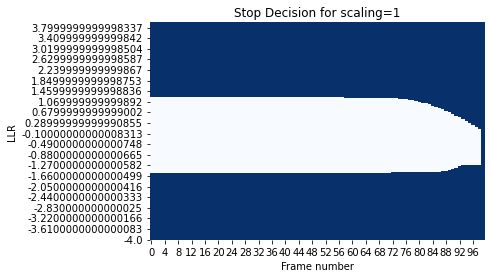

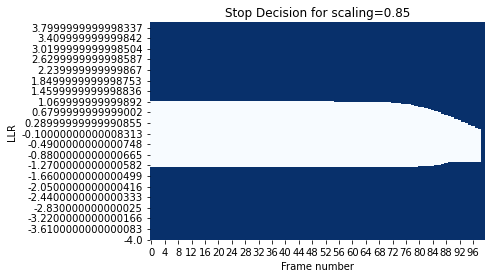

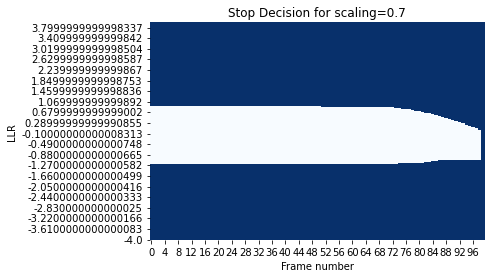

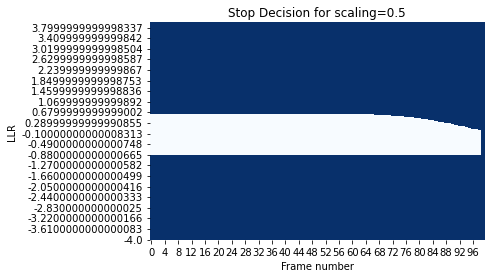

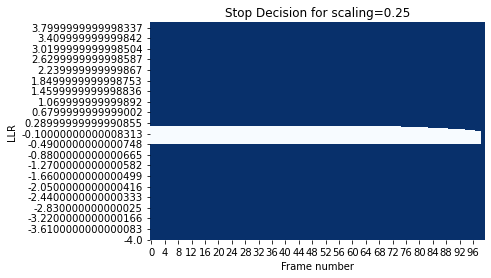

In [63]:
# plot the decision boundaries per scaling

df = pcorrect_df
# Separate data for occluded_rows 2 and 6
df_occluded_1 = df[df['scaling'] == 1]
df_occluded_085 = df[df['scaling'] == 0.85]
df_occluded_07 = df[df['scaling'] == 0.7]
df_occluded_05 = df[df['scaling'] == 0.5]
df_occluded_03 = df[df['scaling'] == 0.25]


# Function to create heatmap
def create_heatmap(df, title):
    pivot_table = df.pivot("LLR", "frame","stop_decision")
    ax=sns.heatmap(pivot_table, cmap="Blues", cbar=False)
    ax.invert_yaxis()  # Reverse the y-axis
    plt.title(title)
    plt.xlabel("Frame number")
    plt.ylabel("LLR")
    plt.show()

# Create heatmaps
create_heatmap(df_occluded_1, "Stop Decision for scaling=1")
create_heatmap(df_occluded_085, "Stop Decision for scaling=0.85")
create_heatmap(df_occluded_07, "Stop Decision for scaling=0.7")
create_heatmap(df_occluded_05, "Stop Decision for scaling=0.5")
create_heatmap(df_occluded_03, "Stop Decision for scaling=0.25")


## Get thresholds

The thresholds are the lowest positive stopping point and the highest negative stopping point, at time point 0.

In [64]:
thresholds = {}

for scaling in scalings:
    relevant_df = pcorrect_df[(pcorrect_df.frame==0) & (pcorrect_df.scaling==scaling)]
    upper_threshold = relevant_df[(relevant_df.LLR>0) & (relevant_df.stop_decision==1)].iloc[0].LLR
    lower_threshold = relevant_df[(relevant_df.LLR<0) & (relevant_df.stop_decision==1)].iloc[-1].LLR
    thresholds[scaling] = (lower_threshold,upper_threshold)

In [65]:
#the expected number of time points until "target absent" decision, assuming a series of zeros
[thresholds[scaling][0]/LLRs[0,scaling] for scaling in scalings]

[18.201501778979058,
 18.55337911621151,
 20.69374728976039,
 21.821906865799868,
 24.624153953060794]

Simulate the decision-making process

In [66]:
def run_trial(present,scaling, scaling_mapping):
    
    ## scaling mapping is a mapping from the scaling factor
    ## to participants' beliefs about the scaling factor
    
    decision = np.nan
    frame = 0
    LLR = 0
    num_ones = 0
    
    
    # the thresholds are a function of the agent's belief about the scaling,
    # not of the scaling itself
    trial_thresholds = thresholds[scaling_mapping[scaling]]
    
    while np.isnan(decision):
        
        #evidence is sampled according to the true distribution
        evidence = sample_evidence(present,scaling)
        
        num_ones += evidence;
        
        #beliefs are updated according to the agent's beliefs about the distribution
        LLR += log_likelihood_ratio(evidence,scaling_mapping[scaling])
        
        if LLR>=trial_thresholds[1]:
            decision=1
        elif LLR<=trial_thresholds[0]:
            decision=0
        frame += 1
        
    #post decisional evidence before extracting confidence            
    for _ in range(0):
        evidence = sample_evidence(present, scaling)
        LLR += log_likelihood_ratio(evidence, scaling_mapping[scaling])
        
    if decision==1:
        confidence = np.exp(LLR)/(1+np.exp(LLR))
    elif decision==0:
        confidence = 1/(1+np.exp(LLR))

        
    return((decision,frame,confidence,num_ones))



In [67]:
scaling_mapping_accurate = {1:1, 0.7:0.7}
scaling_mapping_fault1 = {1:0.85, 0.7:0.85}
scaling_mapping_fault2 = {1:1, 0.7:0.5}

run_trial(0,0.7,scaling_mapping_accurate)

(0, 21, 0.77345206449413, 0)

In [68]:
simulated_trials_accurate_df = pd.DataFrame(columns=['present','occluded_rows','trial','decision','RT','confidence','num_ones'])

num_trials = 1000

random.seed(1)

for target_present in [1,0]:
    for scaling in [1,0.7]:
        for trial in range(num_trials):
            occluded_rows = {1:2,0.7:6}[scaling]
            (decision,frame,confidence,num_ones) = run_trial(target_present,scaling, scaling_mapping_accurate)
            simulated_trials_accurate_df.loc[len(simulated_trials_accurate_df)] = [target_present, 
                                occluded_rows, 
                                trial,
                                decision,
                                frame,
                                confidence,
                                num_ones]
            
simulated_trials_accurate_df.to_csv('simulated_data/accum_bernoulli_occlusion.csv', index=False)


## Faulty agent 1

the first metacognitive fault is one where beliefs about stimulus visibility are the same for the two occlusion levels (scaling=0.85 for both).

In [69]:
simulated_trials_fault1_df = pd.DataFrame(columns=['present','occluded_rows','trial','decision','RT','confidence', 'num_ones'])

num_trials = 1000

random.seed(1)

for target_present in [1,0]:
    for scaling in [1,0.7]:
        for trial in range(num_trials):
            occluded_rows = {1:2,0.7:6}[scaling]
            (decision,frame,confidence,num_ones) = run_trial(target_present,scaling, scaling_mapping_fault1)
            simulated_trials_fault1_df.loc[len(simulated_trials_fault1_df)] = [target_present, 
                                occluded_rows, 
                                trial,
                                decision,
                                frame,
                                confidence,
                                num_ones]
            
simulated_trials_fault1_df.to_csv('simulated_data/accum_bernoulli_occlusion_fault1.csv', index=False)

## Faulty agent 2

The second metacognitive fault is one where beliefs about the effects of occlusion on visibility are exaggerated: participants overestimate the effect of high occlusion to be a scaling of 0.5, rather than 0.7 as it really is.

In [70]:
simulated_trials_fault2_df = pd.DataFrame(columns=['present','occluded_rows','trial','decision','RT','confidence','num_ones'])

num_trials = 1000

random.seed(1)

for target_present in [1,0]:
    for scaling in [1,0.7]:
        for trial in range(num_trials):
            occluded_rows = {1:2,0.7:6}[scaling]
            (decision,frame,confidence,num_ones) = run_trial(target_present,scaling, scaling_mapping_fault2)
            simulated_trials_fault2_df.loc[len(simulated_trials_fault2_df)] = [target_present, 
                                occluded_rows, 
                                trial,
                                decision,
                                frame,
                                confidence,
                                num_ones]
            
simulated_trials_fault2_df.to_csv('simulated_data/accum_bernoulli_occlusion_fault2.csv', index=False)